# Label transfer from scRNA-seq dataset via Pearson correlation 

In this notebook, we will show how to transfer labels from a reference single-cell RNA-sequencing (scRNA-seq) dataset via a lightweight approach. We will use Pearson correlation to find the celltype with the highest expression correlation for each cell the spatial transcriptomics datasset, according to [CellSPA](https://github.com/SydneyBioX/CellSPA).

## Load scRNA-seq dataset

We use the scRNA-seq dataset of diffuse large B-cell lymphoma (DLBCL) samples from [Dong et al.](https://www.biorxiv.org/content/10.1101/2024.11.01.621259v1) published on [CellxGene](https://www.biorxiv.org/content/10.1101/2024.11.01.621259v1).

In [1]:
from pathlib import Path

import anndata as ad

scRNAseq_data_path = Path("/g/huber/projects/CODEX/segtraq/data/label_transfer/scRNA_seq_DLBCL_matched_with_2_C1.h5ad")
adata_ref = ad.read(scRNAseq_data_path)

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [2]:
adata_ref

AnnData object with n_obs × n_vars = 29184 × 442
    obs: 'cell_type', 'is_primary_data', 'sample_id'

The counts in the reference dataset are already log-normalized, so we can copy that matrix to a layer called 'logcounts'.

In [3]:
adata_ref.X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.38975334, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(29184, 442))

In [4]:
adata_ref.layers["logcounts"] = adata_ref.X.copy()

We aggregate log-normalized gene expression values (`logcounts`) across cells grouped by their annotated cell type, computing the mean expression per gene within each cell type. This yields a reference expression profile for each cell type.

In [5]:
import numpy as np

logcounts = adata_ref.layers["logcounts"]
# If it's sparse, convert to dense
if not isinstance(logcounts, np.ndarray):
    logcounts = logcounts.toarray()

celltypes = adata_ref.obs["cell_type"]

In [6]:
import pandas as pd

logcounts_df = pd.DataFrame(logcounts, columns=adata_ref.var_names)
logcounts_df["celltype"] = celltypes.values

ref_mean_df = logcounts_df.groupby("celltype").mean()

/tmp/ipykernel_3092810/2272690639.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ref_mean_df = logcounts_df.groupby("celltype").mean()


In [7]:
ref_mean_df

A2M     ABCA1     ACACA     ACADM     ACKR1     ACKR4  \
celltype                                                                   
B             0.000000  0.016769  0.156024  0.159486  0.000000  0.022256   
DC_pc         0.036694  0.169812  0.117063  0.444065  0.004440  0.003707   
Endothelia    1.471162  0.178528  0.270104  0.289596  0.885165  0.013624   
Epithelia     0.019746  0.080427  0.254660  0.178775  0.001124  0.026345   
Fibro_Muscle  0.266040  0.312430  0.264807  0.343359  0.072844  0.003145   
Mono_Macro    0.656003  0.890168  0.149249  0.331428  0.014655  0.002430   
NK            0.021211  0.106054  0.201798  0.357114  0.005284  0.000000   
Pericyte      2.253352  0.360183  0.252609  0.435539  0.326374  0.000000   
T_CD4         0.029272  0.077661  0.152805  0.257307  0.008759  0.000000   
T_CD8         0.031461  0.045086  0.151711  0.311616  0.004273  0.001105   
T_dividing    0.051053  0.032399  0.196901  0.487031  0.003520  0.000000   
Tumor_DLBCL   0.017330  0.074456  0.278579  0.419433  0.004762  0.000889   
cDC           0.077264  0.341498  0.163797  0.296956  0.021874  0.005103   

                 ACTA2    ADAM10    ADAM17     ADCY7  ...  IL9  IGLC3  HMGB1  \
celltype                                              ...                      
B             0.050791  0.213838  0.229673  0.270148  ...  0.0    0.0    0.0   
DC_pc         0.140305  0.437622  0.294588  0.784672  ...  0.0    0.0    0.0   
Endothelia    0.112109  0.361705  0.256111  0.163421  ...  0.0    0.0    0.0   
Epithelia     0.017461  0.119152  0.206132  0.108029  ...  0.0    0.0    0.0   
Fibro_Muscle  0.434594  0.369848  0.277516  0.193193  ...  0.0    0.0    0.0   
Mono_Macro    0.114052  0.358778  0.334295  0.585345  ...  0.0    0.0    0.0   
NK            0.101637  0.559331  0.245895  0.659352  ...  0.0    0.0    0.0   
Pericyte      0.803320  0.553716  0.318709  0.157481  ...  0.0    0.0    0.0   
T_CD4         0.137884  0.459278  0.233179  0.363228  ...  0.0    0.0    0.0   
T_CD8         0.106523  0.336085  0.214291  0.386563  ...  0.0    0.0    0.0   
T_dividing    0.150578  0.765854  0.408252  0.345907  ...  0.0    0.0    0.0   
Tumor_DLBCL   0.196989  0.418151  0.366993  0.365700  ...  0.0    0.0    0.0   
cDC           0.095915  0.394451  0.305254  0.900343  ...  0.0    0.0    0.0   

              GNAS  IL22  IGLC2  DRAIC  ANGPT2  ICOSLG  IL6ST  
celltype                                                       
B              0.0   0.0    0.0    0.0     0.0     0.0    0.0  
DC_pc          0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Endothelia     0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Epithelia      0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Fibro_Muscle   0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Mono_Macro     0.0   0.0    0.0    0.0     0.0     0.0    0.0  
NK             0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Pericyte       0.0   0.0    0.0    0.0     0.0     0.0    0.0  
T_CD4          0.0   0.0    0.0    0.0     0.0     0.0    0.0  
T_CD8          0.0   0.0    0.0    0.0     0.0     0.0    0.0  
T_dividing     0.0   0.0    0.0    0.0     0.0     0.0    0.0  
Tumor_DLBCL    0.0   0.0    0.0    0.0     0.0     0.0    0.0  
cDC            0.0   0.0    0.0    0.0     0.0     0.0    0.0  

[13 rows x 442 columns]

# Load spatialData object

Next, we load the spatialdata object of a Xenium DLBCL sample.

In [8]:
import spatialdata as sd

sdata = sd.read_zarr(
    "/g/huber/projects/GSK_lazic/B_NHL/BNHL_RICOVER/tma_2/2_C1/proseg_output/spatialData_2_C1_proseg.zarr"
)

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 're

We perform quality control steps (filtering based on #transcripts and #genes per cell) and log-normalization. 

In [9]:
adata = sdata["table"]

In [131]:
import scanpy as sc

import segtraq as st

# Compute QC metrics
transcript_counts = st.bl.transcripts_per_cell(sdata)
gene_counts = st.bl.genes_per_cell(sdata)

transcript_counts.index = transcript_counts.index.astype(str)
gene_counts.index = gene_counts.index.astype(str)

transcript_counts_filtered = transcript_counts.loc[adata.obs_names]
gene_counts_filtered = gene_counts.loc[adata.obs_names]

adata.obs["total_transcripts"] = transcript_counts_filtered["transcript_count"]
adata.obs["total_genes"] = gene_counts_filtered["gene_count"]

In [144]:
adata.obs

centroid_x  centroid_y  cell_size  axis_minor_length  \
cell_id                                                         
1         377.79850   513.17664  395.71875           6.590376   
2         349.86170   643.56384   92.53125           2.653300   
3         401.73760   398.32178  397.68750           5.502993   
4         257.44656   319.80533  773.71875           9.718573   
5         195.35858   549.35860  194.90625           3.843169   
...             ...         ...        ...                ...   
5843      539.39000   343.35000  196.87500           6.445665   
5844      256.99690   636.03420  316.96875           7.896618   
5845      310.64035   493.85090  112.21875           6.976622   
5846      366.64166   153.53334  236.25000           8.121170   
5847      494.74417   190.87209  169.31250           8.103957   

         axis_major_length  centroid-0  centroid-1  eccentricity  solidity  \
cell_id                                                                      
1                 8.878127  512.720930  376.953488      0.670050  0.860000   
2                 5.366563  643.600000  349.000000      0.869227  0.500000   
3                 9.527791  396.305556  400.916667      0.816339  0.800000   
4                11.625859  319.301205  257.168675      0.548814  0.813725   
5                 5.055352  548.785714  194.928571      0.649668  0.875000   
...                    ...         ...         ...           ...       ...   
5843             16.611864  343.063492  539.158730      0.921653  0.684783   
5844             12.941854  636.506667  256.333333      0.792277  0.842697   
5845              7.382183  493.272727  310.151515      0.326891  0.733333   
5846             12.488528  152.528571  366.328571      0.759686  0.777778   
5847              8.811781  190.180000  494.300000      0.392685  0.847458   

         perimeter sample_id TMA       region  mask_id  total_transcripts  \
cell_id                                                                     
1        24.899495      2_C1   2  cell_labels        1                993   
2         0.000000      2_C1   2  cell_labels        2                985   
3        21.071068      2_C1   2  cell_labels        3                959   
4        34.384776      2_C1   2  cell_labels        4                932   
5        11.414214      2_C1   2  cell_labels        5                926   
...            ...       ...  ..          ...      ...                ...   
5843     40.798990      2_C1   2  cell_labels     5843                 61   
5844     35.142136      2_C1   2  cell_labels     5844                 61   
5845     24.727922      2_C1   2  cell_labels     5845                 60   
5846     36.556349      2_C1   2  cell_labels     5846                 60   
5847     26.384776      2_C1   2  cell_labels     5847                 60   

         total_genes  
cell_id               
1                 73  
2                 89  
3                136  
4                161  
5                 47  
...              ...  
5843              85  
5844              41  
5845             109  
5846              46  
5847              33  

[5845 rows x 16 columns]

In [133]:
# Filter outliers
qc_range = {"total_transcripts": (10, 2000), "total_genes": (5, np.inf)}

for key, (low, high) in qc_range.items():
    mask = (adata.obs[key] >= low) & (adata.obs[key] <= high)
    adata = adata[mask.to_numpy()].copy()

In [134]:
# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

/home/lazic/miniforge3/envs/sc_analysis_sdata/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


## Label transfer via correlation

Now, we compute the Pearson correlation between each query cell in the processed `AnnData` object and the mean expression profiles of reference cell types.

We first identify the common genes between the query data and the reference matrix, and then compute a correlation matrix where each entry reflects the similarity between a query cell and a reference cell type.

For each query cell, we:

Assign the most correlated reference cell type (i.e., the one with the highest Pearson correlation),

Store both the correlation value and the predicted cell type.

This provides a label transfer from the reference to the query dataset based on global transcriptomic similarity.

In [ ]:
from anndata import AnnData
from scipy.spatial.distance import cdist


def assign_celltype_by_pearson(adata: AnnData, ref_mean_df: pd.DataFrame, layer: str = "logcounts") -> pd.DataFrame:
    """
    Assigns cell types to cells in `adata` by computing Pearson correlation
    with reference expression profiles.

    Parameters
    ----------
    adata : AnnData
        Query dataset with gene expression data in the specified layer.
    ref_mean_df : pd.DataFrame
        Reference expression matrix with shape (cell_types x genes).
    layer : str, default="logcounts"
        Layer in `adata` to use for expression values.

    Returns
    -------
    pd.DataFrame
        DataFrame with `cell_id` and assigned `celltype`.
    """
    # TODO - check if cdist does really Pearson correlation

    # Extract query expression data
    X_query = pd.DataFrame(
        (adata.layers[layer].toarray() if hasattr(adata.layers[layer], "toarray") else adata.layers[layer]),
        index=adata.obs_names,
        columns=adata.var_names,
    )

    # Align gene order
    common_genes = X_query.columns.intersection(ref_mean_df.columns)
    if len(common_genes) == 0:
        raise ValueError("No common genes found between query and reference.")

    X_query = X_query[common_genes]
    X_ref = ref_mean_df[common_genes]

    # Compute Pearson correlation (1 - correlation distance)
    cor_mat = 1 - cdist(X_query.values, X_ref.values, metric="correlation")
    cor_mat_df = pd.DataFrame(cor_mat, index=adata.obs_names, columns=X_ref.index)

    # Assign best-matching reference cell type
    best_celltype = cor_mat_df.idxmax(axis=1)

    # Return as DataFrame
    return pd.DataFrame({"cell_id": adata.obs_names, "celltype": best_celltype.values})

In [146]:
result_df = assign_celltype_by_pearson(adata, ref_mean_df)

/tmp/ipykernel_2382657/4082630372.py:48: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_celltype = cor_mat_df.idxmax(axis=1)


In [158]:
result_df["celltype"].value_counts()

celltype
Tumor_DLBCL     2293
T_CD8            952
Mono_Macro       789
T_CD4            599
T_dividing       521
Fibro_Muscle     204
cDC              134
Pericyte         123
B                100
Endothelia        62
NK                35
DC_pc             23
Epithelia          6
Name: count, dtype: int64

In [156]:
result_df.set_index("cell_id", inplace=True)
adata.obs["celltype_corr"] = result_df.loc[adata.obs_names, "celltype"]

In [163]:
# define colors for cell types

col_celltype = {
    "B": "#fb8072",
    "cDC": "#bc80bd",
    "DC_pc": "#910290",
    "Endothelia": "#fdb462",
    "Epithelia": "#959059",
    "Fibro_Muscle": "#fed9a6",
    "Mono_Macro": "#a6cee3",
    "NK": "#2782bb",
    "Pericyte": "#d2cd7e",
    "T_CD4": "#3c7761",
    "T_CD4_reg": "#66a61e",
    "T_CD8": "#66c2a5",
    "T_dividing": "#1b9e77",
    "Tumor_DLBCL": "#d45943",
}

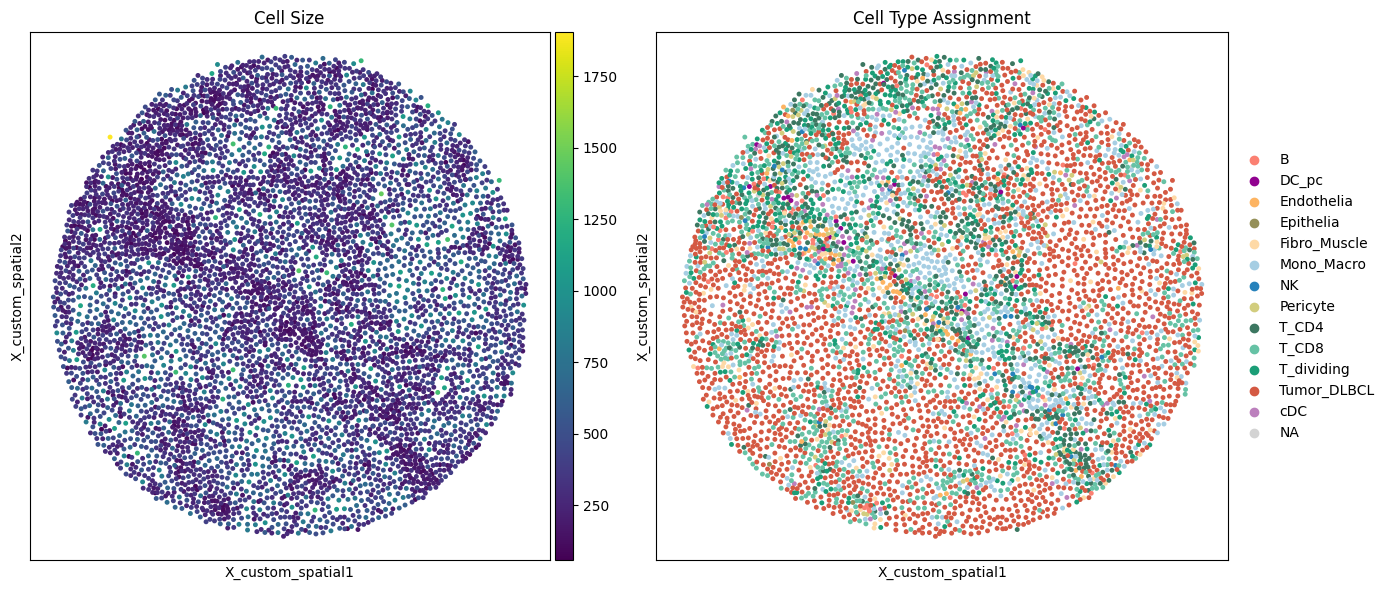

In [170]:
import matplotlib.pyplot as plt

# Set up side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Cell size
sc.pl.embedding(
    adata,
    basis="X_custom_spatial",
    color="cell_size",
    size=50,
    ax=axs[0],
    show=False,
    title="Cell Size",
)

# Plot 2: Cell types with custom colors
sc.pl.embedding(
    adata,
    basis="X_custom_spatial",
    color="celltype_corr",
    size=50,
    palette=col_celltype,  # your custom palette from before
    ax=axs[1],
    show=False,
    title="Cell Type Assignment",
)

plt.tight_layout()
plt.show()